In [1]:
# Imports
import pandas as pd
import numpy as np
import os
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, os.getcwd() + '/helpers')
from helpers_get_date import get_date
from helpers_get_directories import get_directories
from helpers_replace_non_alphanumeric import replace_non_alphanumeric

# Grabbing Today's date
date = get_date()

# Define paths to all the directories within
paths = get_directories(os.getcwd() + '/../data/')
paths.update(get_directories(os.getcwd() + '/../results/'))

# # List all paths
# print('List of paths:')
# print('\n'.join(list(paths.keys())))


# Function

# Data

In [2]:
# Directory to duplicate and move the sub-directories too
path_for_cps = paths['results_alphafold_levi_from_riboviria_w_custom_msa']
path_for_cps += 'alphafolds_of_classified_coats/'


In [2]:
# Grab all pdb files for top ranking ORFs

# Imports
import glob

# Define
file_format = path_for_cps + '*/*rank_001*.pdb'

# Grab all the rank 001 pdb files
filelist = glob.glob(file_format)
filelist.sort()

# Count
cnt = len(filelist)

# Print
print(f'There are {cnt} entries within the directory of interest.\n')

# Preview
filelist[:2]


In [4]:
# Initialize
filenames = []

# Loop
for file in filelist:
    
    # Parse
    name = file.split('/')[-1]
    
    # Adjust
    name = name.split('_unre')[0]
    
    # Append
    filenames.append(name)


# DSSP

In [5]:
# Imports
from Bio.PDB import DSSP, PDBParser

# Initialize
ss_seqs = {}

# Loop
for pdb_file, name in zip(filelist, filenames):
    
    # Create PDBParser class
    p = PDBParser()
    
    # Grab structure
    structure = p.get_structure("X", pdb_file)
    
    # Grab model
    model = structure[0]
    
    # Calculate the ss
    dssp = DSSP(model, pdb_file)
    
    # Grab ss sequence
    ss_seq = [amino_acid[2] for amino_acid in dssp]
    
    # Adjust
    ss_seq = ''.join(ss_seq)
    
    # Append
    ss_seqs[name] = ss_seq


In [6]:
# Adjust the ss to just be a monomer
for name, ss in ss_seqs.items():
    
    # Length
    llen = name.split('_sens')[0]
    llen = llen.split('start_')[-1]
    llen = llen.split('_end_')
    llen = [int(i) for i in llen]
    llen = np.abs(llen[0] - llen[1])
    llen = llen / 3
    llen = int(llen)
    llen = llen - 1
    
    ss_seqs[name] = ss[:llen]


# SS propensity

In [7]:
def replace_characters(s):
    return ''.join(['-' if char not in ['H', 'B', 'E'] else char for char in s])


In [8]:
# Adjust ss_seqs
ss_seqs_adj = {name : replace_characters(seq) for name, seq in ss_seqs.items()}


In [9]:
def make_num_lst_from_string(s, val):
    
    # Converter
    char_to_num = {'-' : 0, 'H' : val, 'B' : -val, 'E' : -val}

    return [char_to_num[char] for char in s]


In [10]:
# Make val strings
ss_seqs_adj_vals = {name : make_num_lst_from_string(seq, i + 1) for i, (name, seq) in enumerate(ss_seqs_adj.items())}


In [11]:
def group_consecutive_numbers(lst):
    if not lst:  # Check if the list is empty
        return []

    sublists = []
    current_sublist = [lst[0]]

    for i in range(1, len(lst)):
        if lst[i] == lst[i - 1]:
            current_sublist.append(lst[i])
        else:
            sublists.append(current_sublist)
            current_sublist = [lst[i]]

    sublists.append(current_sublist)
    return sublists

In [12]:
# Make group consecutive numbers
ss_seqs_adj_vals_grouped = {name : group_consecutive_numbers(lst) for name, lst in ss_seqs_adj_vals.items()}


In [13]:
def make_lst_of_colors(lst, val):

    # Make a character dictionary
    num_to_color = {val : 'darkorange', -val : 'blue', 0 : 'black'}
    
    lst_of_colors = [num_to_color[l[0]] for i, l in enumerate(lst)]
    
    return lst_of_colors


In [14]:
def make_lst_of_symbols(lst, val):

    # Make a character dictionary
    num_to_symbol = {val : '*', -val : 'd', 0 : '-'}
    lst_of_symbols = [num_to_symbol[l[0]] for i, l in enumerate(lst)]
    
    return lst_of_symbols


In [15]:
def make_lst_of_markersizes(lst, val):
    
    size = 12

    # Make a character dictionary
    num_to_markersize = {val : size, -val : size, 0 : 5}
    lst_of_markersizes = [num_to_markersize[l[0]] for i, l in enumerate(lst)]
    
    return lst_of_markersizes


In [16]:
# Make a list of colors
lst_of_lst_of_colors = {name : make_lst_of_colors(lst, i + 1) for i, (name, lst) in enumerate(ss_seqs_adj_vals_grouped.items())}


In [17]:
# Make a list of symbols
lst_of_lst_of_symbols = {name : make_lst_of_symbols(lst, i + 1) for i, (name, lst) in enumerate(ss_seqs_adj_vals_grouped.items())}


In [18]:
# Make a list of markersizes
lst_of_lst_of_markersizes = {name : make_lst_of_markersizes(lst, i + 1) for i, (name, lst) in enumerate(ss_seqs_adj_vals_grouped.items())}


In [19]:
# Convert all the numbers to be positive
ss_seqs_adj_vals_grouped = {name : [list(np.abs(sub)) for sub in lst] for name, lst in ss_seqs_adj_vals_grouped.items()}


In [20]:
def replace_zeros_with_unique_value(lists):
    # Find the unique non-zero value in the entire list of lists
    unique_value = next((x for sublist in lists for x in sublist if x != 0), None)

    # Replace all 0s in each sublist with this unique non-zero value
    for i in range(len(lists)):
        lists[i] = [unique_value if x == 0 else x for x in lists[i]]

    return lists


In [21]:
# Convert all the 0s to their values
ss_seqs_adj_vals_grouped = {name : replace_zeros_with_unique_value(lst) for name, lst in ss_seqs_adj_vals_grouped.items()}


In [22]:
def group_indices_of_consecutive_numbers(lst):
    if not lst:  # Check if the list is empty
        return []

    grouped_indices = []
    current_indices = [0]

    for i in range(1, len(lst)):
        if lst[i] == lst[i - 1]:
            current_indices.append(i)
        else:
            grouped_indices.append(current_indices)
            current_indices = [i]

    grouped_indices.append(current_indices)
    return grouped_indices


In [23]:
# Make x list
x_values = {name : group_indices_of_consecutive_numbers(lst) for name, lst in ss_seqs_adj_vals.items()}


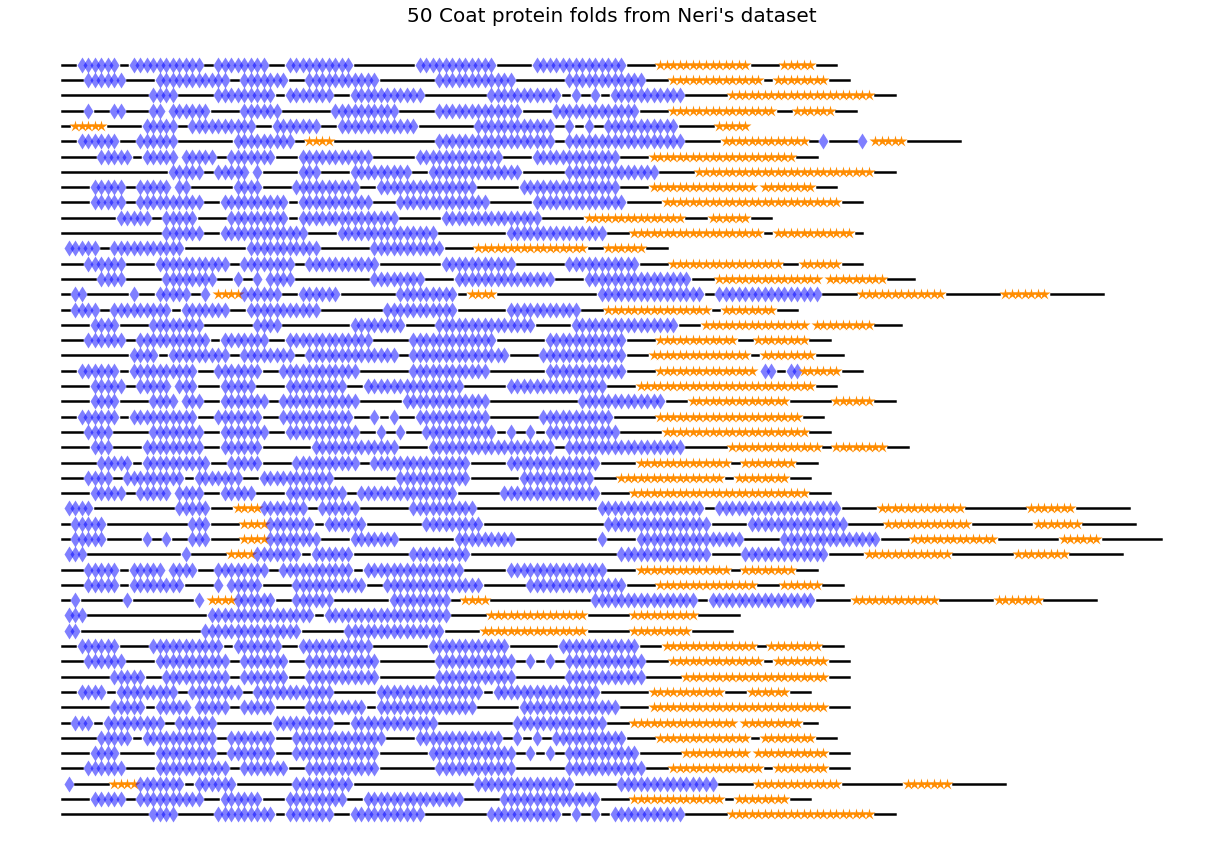

In [24]:
# Imports
import matplotlib.pyplot as plt

# Scale
scale = [10 / 3, 7 / 3]

# Figure
plt.figure(figsize = (6.5 * scale[0], 6.5 * scale[1]))

# Define aa random subset dictionary
subset = {name : ss_seqs_adj_vals_grouped[name] for name in list(ss_seqs_adj_vals_grouped.keys())[:50]}
for name, num_lsts in subset.items():
# for name, num_lsts in ss_seqs_adj_vals_grouped.items():
    
    # Define
    color_lst = lst_of_lst_of_colors[name]
    symbol_lst = lst_of_lst_of_symbols[name]
    markersize_lst = lst_of_lst_of_markersizes[name]
    x_vals = x_values[name]
    
    # Loop
    for i in range(len(num_lsts)):
        
        # Define
        vals = num_lsts[i]
        color = color_lst[i]
        symbol = symbol_lst[i]
        size = markersize_lst[i]
        x = x_vals[i]
        lw = 2.5
        
        # Condition
        if symbol == '-':
            
            # Define
            alpha = 1
        
            # Plot
            plt.plot(x, vals, symbol, color = color, markersize = size, lw = lw, alpha = alpha)
            
        # Conditional
        else:

            # Define
            alpha = 0.5 if symbol != '*' else 1
        
            # Plot
            plt.plot(x, vals, symbol, color = color, markersize = size, lw = lw, alpha = alpha, mec = 'none')

    
# Ticks
plt.locator_params(axis = 'y', nbins = 8)
plt.locator_params(axis = 'x', nbins = 8)
plt.tick_params(axis = 'both', labelsize = 20)

# # Remove ticks
plt.yticks([])
plt.xticks([])

# Labels
plt.ylabel('', fontsize = 20)
plt.title("50 Coat protein folds from Neri's dataset", fontsize = 20)

# Despine
gca = plt.gca()
gca.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
# gca.spines[['bottom']].set_linewidth(2.5)

# Show
plt.show()        


# Align

In [25]:
def replace_characters(s):
    return ''.join(['-' if char not in ['H', 'B', 'E'] else char for char in s])


In [26]:
# Adjust ss_seqs
ss_seqs_adj = {name : replace_characters(seq) for name, seq in ss_seqs.items()}


In [27]:
def make_num_lst_from_string(s, val):
    
    # Converter
    char_to_num = {'-' : 0, 'H' : val, 'B' : -val, 'E' : -val}

    return [char_to_num[char] for char in s]


In [28]:
# Make val strings
ss_seqs_adj_vals = {name : make_num_lst_from_string(seq, i + 1) for i, (name, seq) in enumerate(ss_seqs_adj.items())}


In [29]:
def group_consecutive_numbers(lst):
    if not lst:  # Check if the list is empty
        return []

    sublists = []
    current_sublist = [lst[0]]

    for i in range(1, len(lst)):
        if lst[i] == lst[i - 1]:
            current_sublist.append(lst[i])
        else:
            sublists.append(current_sublist)
            current_sublist = [lst[i]]

    sublists.append(current_sublist)
    return sublists

In [30]:
# Make group consecutive numbers
ss_seqs_adj_vals_grouped = {name : group_consecutive_numbers(lst) for name, lst in ss_seqs_adj_vals.items()}


In [31]:
def convert_lists(input_list):
    """
    Convert all non-zero lists of length 1 in a list of lists to zero lists of the same length.

    Parameters:
    input_list (list): A list of lists of integers.

    Returns:
    list: A new list where all non-zero single-element sublists are converted to [0].
    """
    return [[0] if len(sublist) == 1 and sublist[0] != 0 else sublist for sublist in input_list]


In [32]:
# def convert_lists(input_list):
#     """
#     Convert all non-zero lists of length 1 in a list of lists to zero lists of the same length.

#     Parameters:
#     input_list (list): A list of lists of integers.

#     Returns:
#     list: A new list where all non-zero single-element sublists are converted to [0].
#     """
#     new_lst = []
#     for sublist in input_list:
        
#         if (len(sublist) == 1) and (sublist[0] != 0):
            
#             new_lst.append([0])
            
#         elif (len(sublist) == 2) and (list(set(sublist))[0] != 0):
            
#             new_lst.append([0, 0])
            
#         else:
            
#             new_lst.append(sublist)
            
#     return new_lst


In [33]:
def group_zero_lists(input_list):
    grouped_list = []
    current_group = []

    for sublist in input_list:
        if all(x == 0 for x in sublist):
            current_group.extend(sublist)
        else:
            if current_group:
                grouped_list.append(current_group)
                current_group = []
            grouped_list.append(sublist)

    if current_group:
        grouped_list.append(current_group)

    return grouped_list


In [34]:
# Convert non-zero list of length 1 into zero list of length 1
ss_seqs_adj_vals_grouped = {name : convert_lists(lst_lst) for name, lst_lst in ss_seqs_adj_vals_grouped.items()}


In [35]:
# Group neighboring 0s list together
ss_seqs_adj_vals_grouped = {name : group_zero_lists(lst_lst) for name, lst_lst in ss_seqs_adj_vals_grouped.items()}


In [36]:
def find_last_sublist(main_list, sublist):
    # Length of the main list and the sublist
    len_main = len(main_list)
    len_sub = len(sublist)

    # Start from the end of the main list and move backwards
    for i in range(len_main - len_sub, -1, -1):
        # Check if the sublist matches starting at this index
        if main_list[i:i + len_sub] == sublist:
            return i  # Return the starting index of the match

    return -1  # Return -1 if the sublist is not found; This means that might not be a coat or different class


In [37]:
# Define lst_indecies to align to
ss_seqs_align = {}

# Define
reach = 6

# Pattern to look for
pattern = [0, -1, 0, -1, 0, 1, 0]

# Loop
for name, lst_lst in ss_seqs_adj_vals_grouped.items():
    
    # Define
    digits = [lst[0] for lst in lst_lst]
        
    # Initialize
    digits_adj = []

    # Adjust digits
    for j in digits:

        # Conditional
        if j > 0:

            # Append
            digits_adj.append(1)

        # Conditional
        elif j < 0:

            # Append
            digits_adj.append(-1)

        # Conditional
        else:

            # Append
            digits_adj.append(0)
            
    # Find the last occurence
    idx = find_last_sublist(digits_adj, pattern)
    
    # Conditional
    if idx > 0:
        
        # Append
        ss_seqs_align[name] = idx + 3


In [38]:
def generate_aligned_x_values(original_list, target_index):

    # Calculate the start value for numbering
    # The start value is such that the last element of the sublist at index 12 becomes 200
    elements_before_target = sum(len(sublist) for sublist in original_list[:target_index])
    last_value_target_sublist = 200
    start_value = last_value_target_sublist - len(original_list[target_index]) + 1 - elements_before_target

    # Generate the new list with adjusted values
    new_list = []
    current_value = start_value
    for sublist in original_list:
        new_sublist = list(range(current_value, current_value + len(sublist)))
        new_list.append(new_sublist)
        current_value += len(sublist)

    return new_list


In [39]:
# Make x list
x_values = {name : generate_aligned_x_values(ss_seqs_adj_vals_grouped[name], idx) for name, idx in ss_seqs_align.items()}


In [40]:
# Adjust ss_seqs
ss_seqs_adj = {name : replace_characters(seq) for name, seq in ss_seqs.items() if name in x_values.keys()}


In [41]:
# Make val strings
ss_seqs_adj_vals = {name : make_num_lst_from_string(seq, i + 1) for i, (name, seq) in enumerate(ss_seqs_adj.items())}


In [42]:
# Make group consecutive numbers
ss_seqs_adj_vals_grouped = {name : group_consecutive_numbers(lst) for name, lst in ss_seqs_adj_vals.items()}


In [43]:
# Convert non-zero list of length 1 into zero list of length 1
ss_seqs_adj_vals_grouped = {name : convert_lists(lst_lst) for name, lst_lst in ss_seqs_adj_vals_grouped.items()}


In [44]:
# Group neighboring 0s list together
ss_seqs_adj_vals_grouped = {name : group_zero_lists(lst_lst) for name, lst_lst in ss_seqs_adj_vals_grouped.items()}


In [45]:
def make_lst_of_colors(lst, val):

    # Make a character dictionary
    num_to_color = {val : 'darkorange', -val : 'blue', 0 : 'black'}
    
    lst_of_colors = [num_to_color[l[0]] for i, l in enumerate(lst)]
    
    return lst_of_colors


In [46]:
def make_lst_of_symbols(lst, val):

    # Make a character dictionary
    num_to_symbol = {val : '*', -val : 'd', 0 : '-'}
    lst_of_symbols = [num_to_symbol[l[0]] for i, l in enumerate(lst)]
    
    return lst_of_symbols


In [47]:
def make_lst_of_markersizes(lst, val):
    
    size = 20

    # Make a character dictionary
    num_to_markersize = {val : size, -val : size, 0 : 5}
    lst_of_markersizes = [num_to_markersize[l[0]] for i, l in enumerate(lst)]
    
    return lst_of_markersizes


In [48]:
# Make a list of colors
lst_of_lst_of_colors = {name : make_lst_of_colors(lst, i + 1) for i, (name, lst) in enumerate(ss_seqs_adj_vals_grouped.items())}


In [49]:
# Make a list of symbols
lst_of_lst_of_symbols = {name : make_lst_of_symbols(lst, i + 1) for i, (name, lst) in enumerate(ss_seqs_adj_vals_grouped.items())}


In [50]:
# Make a list of markersizes
lst_of_lst_of_markersizes = {name : make_lst_of_markersizes(lst, i + 1) for i, (name, lst) in enumerate(ss_seqs_adj_vals_grouped.items())}


In [51]:
# Convert all the numbers to be positive
ss_seqs_adj_vals_grouped = {name : [list(np.abs(sub)) for sub in lst] for name, lst in ss_seqs_adj_vals_grouped.items()}


In [52]:
def replace_zeros_with_unique_value(lists):
    # Find the unique non-zero value in the entire list of lists
    unique_value = next((x for sublist in lists for x in sublist if x != 0), None)

    # Replace all 0s in each sublist with this unique non-zero value
    for i in range(len(lists)):
        lists[i] = [unique_value if x == 0 else x for x in lists[i]]

    return lists


In [53]:
# Convert all the 0s to their values
ss_seqs_adj_vals_grouped = {name : replace_zeros_with_unique_value(lst) for name, lst in ss_seqs_adj_vals_grouped.items()}


In [54]:
def replace_number_in_list(numbers_list, old_number, new_number):
    for i in range(len(numbers_list)):
        if numbers_list[i] == old_number:
            numbers_list[i] = new_number
    return numbers_list


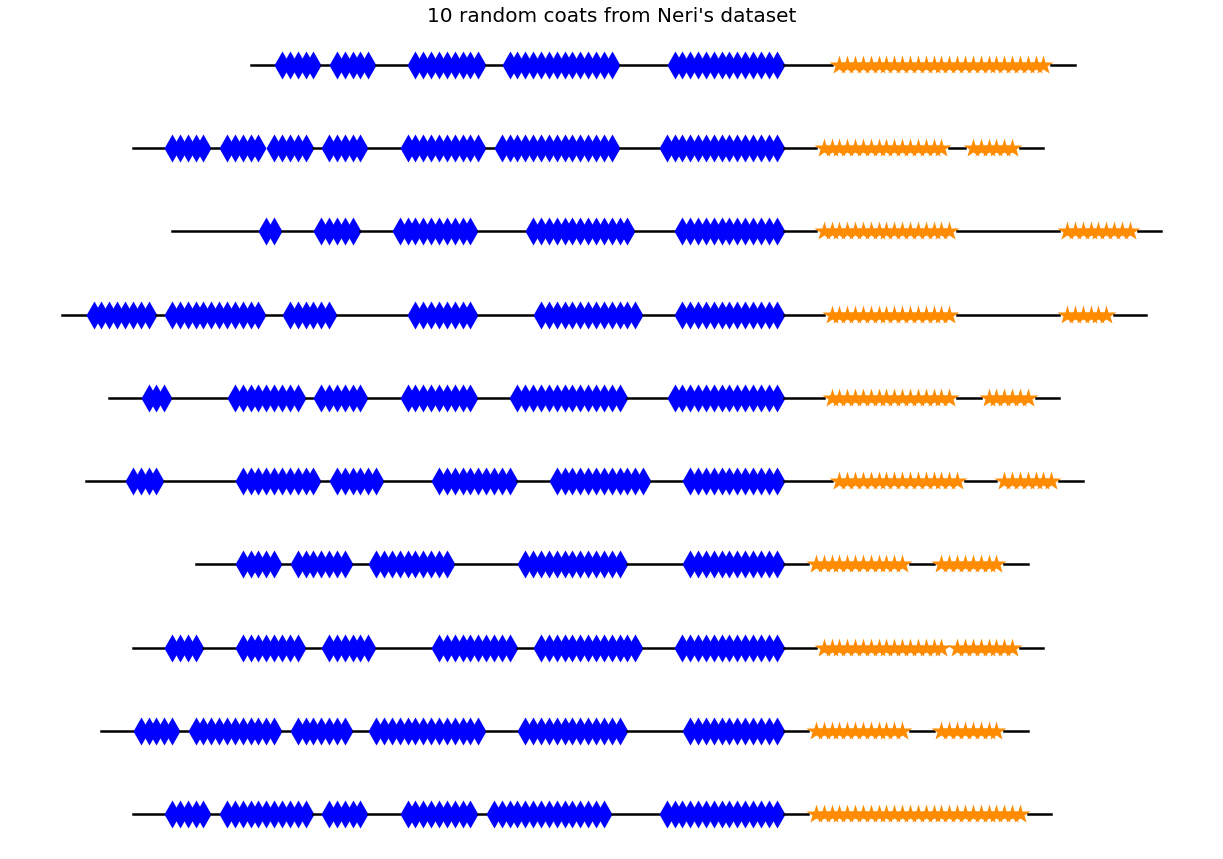

In [55]:
# Imports
import matplotlib.pyplot as plt
import random

# Scale
scale = [10 / 3, 7 / 3]

# Figure
plt.figure(figsize = (6.5 * scale[0], 6.5 * scale[1]))

# Define
n = 10

# Define random list of keys
random_key_lst = random.sample(ss_seqs_adj_vals_grouped.keys(), n)

# Define aa random subset dictionary
subset = {name : ss_seqs_adj_vals_grouped[name] for name in random_key_lst}

for k, (name, num_lsts) in enumerate(subset.items()):
# for name, num_lsts in ss_seqs_adj_vals_grouped.items():
    
    # Define
    color_lst = lst_of_lst_of_colors[name]
    symbol_lst = lst_of_lst_of_symbols[name]
    markersize_lst = lst_of_lst_of_markersizes[name]
    x_vals = x_values[name]
    
    # Loop
    for i in range(len(num_lsts)):
        
        # Define
        vals = num_lsts[i]
        color = color_lst[i]
        symbol = symbol_lst[i]
        size = markersize_lst[i]
        x = x_vals[i]
        lw = 2.5
        
        # Adjust vals
        vals = replace_number_in_list(vals, vals[0], k + 1)
                
        # Condition
        if symbol == '-':
            
            # Define
            alpha = 1
        
            # Plot
            plt.plot(x, vals, symbol, color = color, markersize = size, lw = lw, alpha = alpha)
            
        # Conditional
        else:

            # Define
            alpha = 1 if symbol != '*' else 1
        
            # Plot
            plt.plot(x, vals, symbol, color = color, markersize = size, lw = lw, alpha = alpha, mec = 'none')

    
# Ticks
plt.locator_params(axis = 'y', nbins = 8)
plt.locator_params(axis = 'x', nbins = 8)
plt.tick_params(axis = 'both', labelsize = 20)

# # Remove ticks
plt.yticks([])
plt.xticks([])

# Labels
plt.ylabel('', fontsize = 20)
plt.title(f"{n} random coats from Neri's dataset", fontsize = 20)

# Despine
gca = plt.gca()
gca.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
# gca.spines[['bottom']].set_linewidth(2.5)

# # Save fig
# plt.savefig('/Users/daniel/Desktop/temp.svg', transparent = True, format = 'svg', bbox_inches = 'tight')

# Show
plt.show()        


# Convert to arrows

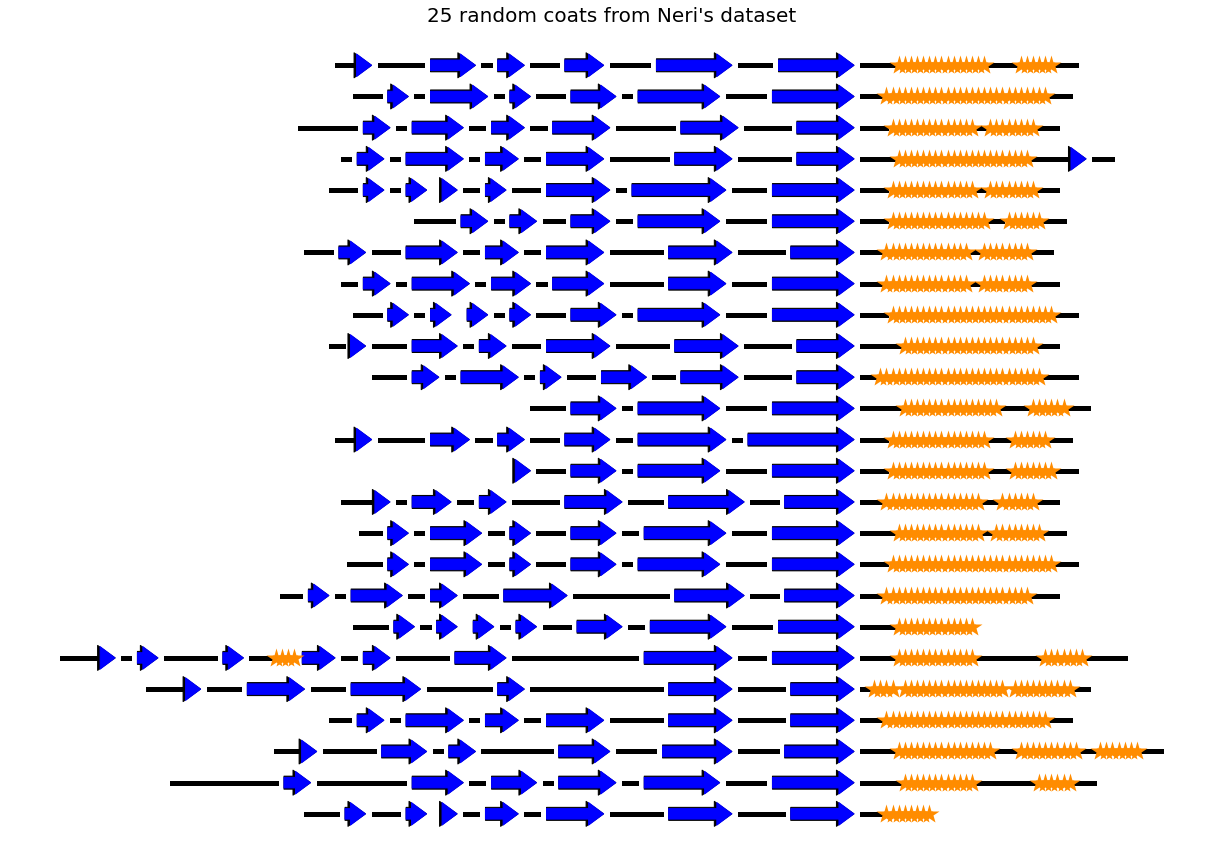

In [56]:
# Imports
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, ArrowStyle
import random

# Scale
scale = [10 / 3, 7 / 3]

# Figure
plt.figure(figsize = (6.5 * scale[0], 6.5 * scale[1]))

# Define
n = 25

# Define random list of keys
random_key_lst = random.sample(ss_seqs_adj_vals_grouped.keys(), n)

# Define aa random subset dictionary
subset = {name : ss_seqs_adj_vals_grouped[name] for name in random_key_lst}
    
for k, name in enumerate(list(subset.keys())):
    
    # Define
    num_lsts = subset[name]
    
    # Define
    color_lst = lst_of_lst_of_colors[name]
    symbol_lst = lst_of_lst_of_symbols[name]
    markersize_lst = lst_of_lst_of_markersizes[name]
    x_vals = x_values[name]
    
    # Loop
    for i in range(len(num_lsts)):
        
        # Define
        vals = num_lsts[i]
        color = color_lst[i]
        symbol = symbol_lst[i]
        size = markersize_lst[i]
        x = x_vals[i]
        lw = 2.5
        
        # Adjust vals
        vals = replace_number_in_list(vals, vals[0], k + 1)
                
        # Condition: No SS
        if symbol == '-':
            
            # Define
            alpha = 1
        
            # Plot
            plt.plot(x, vals, symbol, color = color, markersize = size, lw = 2 * lw, alpha = alpha, zorder = 1)
            
        # Conditional
        else:
                        
            # Conditional: Beta sheet
            if symbol != '*':
                
                # Conditional
                if len(x):
                
                    # Define start and end points for the arrow
                    start_point = (x[0], vals[0])
                    end_point = (x[-1], vals[-1])
                    
                    scale = 1.5

                    # Parameters for the small (inner) arrow
                    head_length_small = 10 * scale # Head length
                    head_width_small = 15 * scale  # Head width
                    tail_width_small = 7 * scale  # Tail width

                    # Define the additional margin for the border arrow
                    border_margin = 2.5

                    # Create the border arrow (larger size)
                    head_length_border = head_length_small + border_margin
                    head_width_border = head_width_small + border_margin
                    tail_width_border = tail_width_small + border_margin

                    # Define custom arrow styles
                    arrowstyle_border = ArrowStyle.Simple(head_length=head_length_border, head_width=head_width_border, tail_width=tail_width_border)
                    arrowstyle_small = ArrowStyle.Simple(head_length=head_length_small, head_width=head_width_small, tail_width=tail_width_small)

                    # Create the arrow patches
                    arrow_border = FancyArrowPatch(start_point, end_point, arrowstyle=arrowstyle_border, color='black')
                    arrow_small = FancyArrowPatch(start_point, end_point, arrowstyle=arrowstyle_small, color=color)

                    # Add both arrows to the plot, border first, then the main color
                    plt.gca().add_patch(arrow_border)
                    plt.gca().add_patch(arrow_small)
                    
                    
                # Conditional
                else:
                    
                    # Plot
                    plt.plot(x, vals, symbol, color = color, markersize = size, lw = 2 * lw, alpha = alpha, zorder = 1)
                
            # Conditional: Alpha-helix
            else:
        
                # Plot
                plt.plot(x, vals, symbol, color = color, markersize = size, lw = lw, alpha = alpha, mec = 'none')

    
# Ticks
plt.locator_params(axis = 'y', nbins = 8)
plt.locator_params(axis = 'x', nbins = 8)
plt.tick_params(axis = 'both', labelsize = 20)

# # Remove ticks
plt.yticks([])
plt.xticks([])

# Labels
plt.ylabel('', fontsize = 20)
plt.title(f"{n} random coats from Neri's dataset", fontsize = 20)

# Despine
gca = plt.gca()
gca.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
# gca.spines[['bottom']].set_linewidth(2.5)

# # Save fig
# plt.savefig('/Users/daniel/Desktop/temp.svg', transparent = True, format = 'svg', bbox_inches = 'tight')

# Show
plt.show()        


# Convert to helicies

In [73]:
def add_adjustable_ovals(ax, start_x_position, end_x_position, center_height=0, edge_line_width=20,
                         angle_of_rotation_deg=15, face_color='white', edge_color='darkorange',
                         r_x=1, r_y=1.5, oval_separation=0.75):
    """
    Adds a series of adjustable ovals to an existing plot.

    Parameters:
    - ax: The axes object to which the ovals will be added.
    - start_x_position: X-axis position where the first oval starts.
    - end_x_position: X-axis position where the last oval ends.
    - center_height: Y-axis position of the center of all ovals.
    - edge_line_width: Line width of the oval edges.
    - angle_of_rotation_deg: Angle of rotation for the ovals, in degrees.
    - face_color: Color of the interior of the ovals.
    - edge_color: Color of the edges of the ovals.
    - r_x: Radius along the X-axis.
    - r_y: Radius along the Y-axis.
    - oval_separation: Distance between the centers of adjacent ovals along the X-axis.
    """
    angle_of_rotation_rad = np.radians(angle_of_rotation_deg)
    theta = np.linspace(0, 2 * np.pi, 1000)

    num_ovals = int((end_x_position - start_x_position) / oval_separation) + 1

    for i in range(num_ovals - 1, -1, -1):
        x_position = start_x_position + i * oval_separation
        x_oval = x_position + r_x * np.cos(theta) * np.cos(angle_of_rotation_rad) + r_y * np.sin(theta) * np.sin(angle_of_rotation_rad)
        y_oval = center_height + r_y * np.cos(theta) * np.sin(angle_of_rotation_rad) - r_y * np.sin(theta) * np.cos(angle_of_rotation_rad)
        ax.fill(x_oval, y_oval, color=face_color, edgecolor=edge_color, linewidth=edge_line_width)


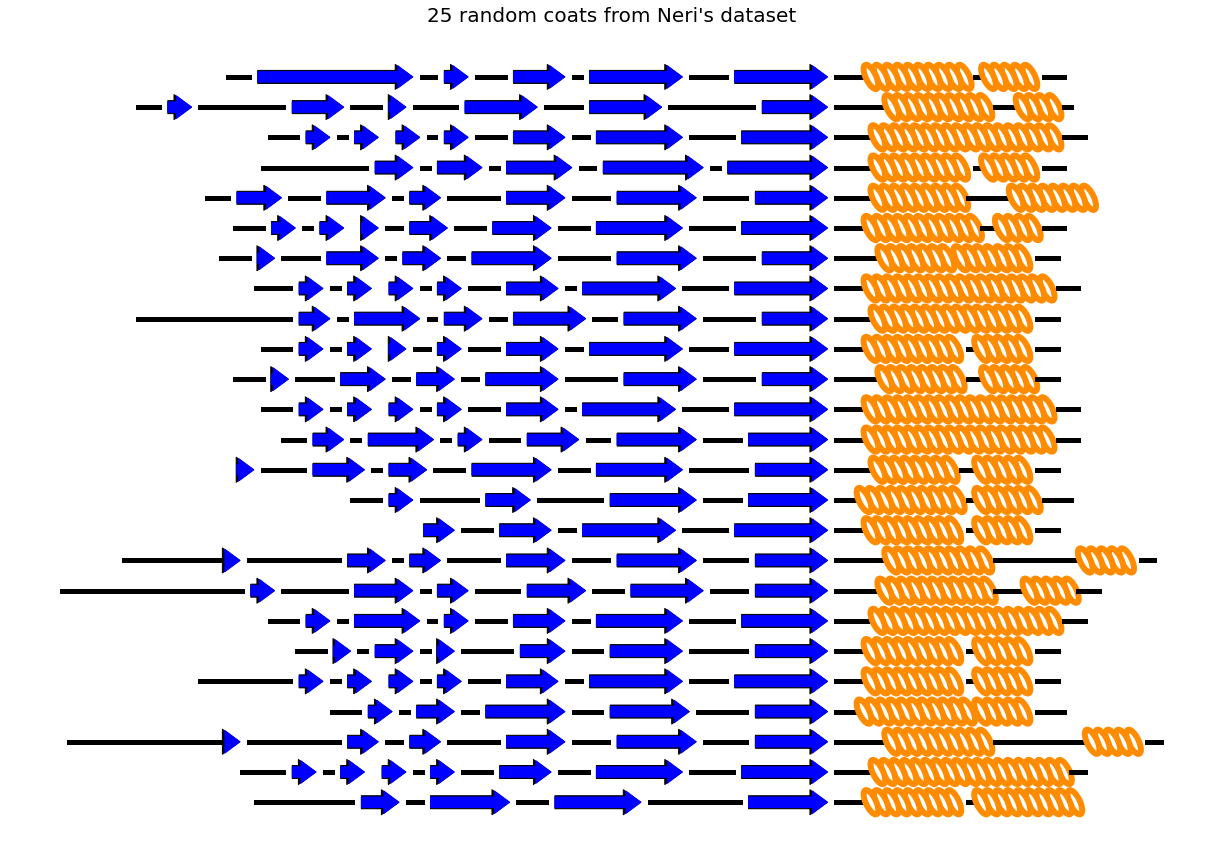

In [104]:
# Imports
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, ArrowStyle
import random

# Scale
scale = [10 / 3, 7 / 3]

# Figure
fig, ax = plt.subplots(figsize=(6.5 * scale[0], 6.5 * scale[1]))

# Define
n = 25

# Define random list of keys
random_key_lst = random.sample(ss_seqs_adj_vals_grouped.keys(), n)

# Define aa random subset dictionary
subset = {name : ss_seqs_adj_vals_grouped[name] for name in random_key_lst}
    
for k, name in enumerate(list(subset.keys())):
    
    # Define
    num_lsts = subset[name]
    
    # Define
    color_lst = lst_of_lst_of_colors[name]
    symbol_lst = lst_of_lst_of_symbols[name]
    markersize_lst = lst_of_lst_of_markersizes[name]
    x_vals = x_values[name]
    
    # Loop
    for i in range(len(num_lsts)):
        
        # Define
        vals = num_lsts[i]
        color = color_lst[i]
        symbol = symbol_lst[i]
        size = markersize_lst[i]
        x = x_vals[i]
        lw = 2.5
        
        # Adjust vals
        vals = replace_number_in_list(vals, vals[0], k + 1)
                
        # Condition: No SS
        if symbol == '-':
            
            # Define
            alpha = 1
        
            # Plot
            ax.plot(x, vals, symbol, color = color, markersize = size, lw = 2 * lw, alpha = alpha, zorder = 1)
            
        # Conditional
        else:
                        
            # Conditional: Beta sheet
            if symbol != '*':
                
                # Conditional
                if len(x):
                
                    # Define start and end points for the arrow
                    start_point = (x[0], vals[0])
                    end_point = (x[-1], vals[-1])
                    
                    scale = 1.5

                    # Parameters for the small (inner) arrow
                    head_length_small = 10 * scale # Head length
                    head_width_small = 15 * scale  # Head width
                    tail_width_small = 7 * scale  # Tail width

                    # Define the additional margin for the border arrow
                    border_margin = 2.5

                    # Create the border arrow (larger size)
                    head_length_border = head_length_small + border_margin
                    head_width_border = head_width_small + border_margin
                    tail_width_border = tail_width_small + border_margin

                    # Define custom arrow styles
                    arrowstyle_border = ArrowStyle.Simple(head_length=head_length_border, head_width=head_width_border, tail_width=tail_width_border)
                    arrowstyle_small = ArrowStyle.Simple(head_length=head_length_small, head_width=head_width_small, tail_width=tail_width_small)

                    # Create the arrow patches
                    arrow_border = FancyArrowPatch(start_point, end_point, arrowstyle=arrowstyle_border, color='black')
                    arrow_small = FancyArrowPatch(start_point, end_point, arrowstyle=arrowstyle_small, color=color)

                    # Add both arrows to the plot, border first, then the main color
                    plt.gca().add_patch(arrow_border)
                    plt.gca().add_patch(arrow_small)
                    
                    
                # Conditional
                else:
                    
                    # Plot
                    ax.plot(x, vals, symbol, color = color, markersize = size, lw = 2 * lw, alpha = alpha, zorder = 1)
                
            # Conditional: Alpha-helix
            else:
                
                r_x = 2  # Temporarily increased for visibility
                r_y = 0.4  # Temporarily increased for visibility
                angle_of_rotation_deg = -60
                edge_line_width = 6
                edge_color = 'darkorange'
                face_color = 'white'
                oval_separation = 1.5  # Adjusted for testing
                start_x_position = x[0]
                end_x_position = x[-1]
                center_height=vals[0]

                add_adjustable_ovals(ax,
                                     start_x_position=start_x_position,
                                     end_x_position=end_x_position,
                                     center_height=center_height,
                                     edge_line_width=edge_line_width,
                                     angle_of_rotation_deg=angle_of_rotation_deg,
                                     face_color=face_color,
                                     edge_color=edge_color,
                                     r_x=r_x,
                                     r_y=r_y,
                                     oval_separation=oval_separation)
    
# Ticks
plt.locator_params(axis = 'y', nbins = 8)
plt.locator_params(axis = 'x', nbins = 8)
plt.tick_params(axis = 'both', labelsize = 20)

# # Remove ticks
plt.yticks([])
plt.xticks([])

# Labels
plt.ylabel('', fontsize = 20)
plt.title(f"{n} random coats from Neri's dataset", fontsize = 20)

# Despine
gca = plt.gca()
gca.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
# gca.spines[['bottom']].set_linewidth(2.5)

# Save fig
# plt.savefig('/Users/daniel/Desktop/temp.svg', transparent = True, format = 'svg', bbox_inches = 'tight')
# plt.savefig('/Users/daniel/Desktop/temp.png', transparent = False, format = 'png', bbox_inches = 'tight', dpi = 1000)

# Show
plt.show()        
